# Lab 5 - K-Means

In [1]:
# Import of used libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import of dataset
df = pd.read_csv('framingham-3.csv')
df.dropna(inplace=True)
df

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4231,1,58,3.0,0,0.0,0.0,0,1,0,187.0,141.0,81.0,24.96,80.0,81.0,0
4232,1,68,1.0,0,0.0,0.0,0,1,0,176.0,168.0,97.0,23.14,60.0,79.0,1
4233,1,50,1.0,1,1.0,0.0,0,1,0,313.0,179.0,92.0,25.97,66.0,86.0,1
4234,1,51,3.0,1,43.0,0.0,0,0,0,207.0,126.5,80.0,19.71,65.0,68.0,0


## 1 - Cluster Analysis via K-Means

- (a) With the elbow method, around 5 or 10 as cluster size should be a good value
- (b) Using the silhouette score to select the best balance between cohesion within clusters and separation we find optimal the interval 2-4 and 10-11

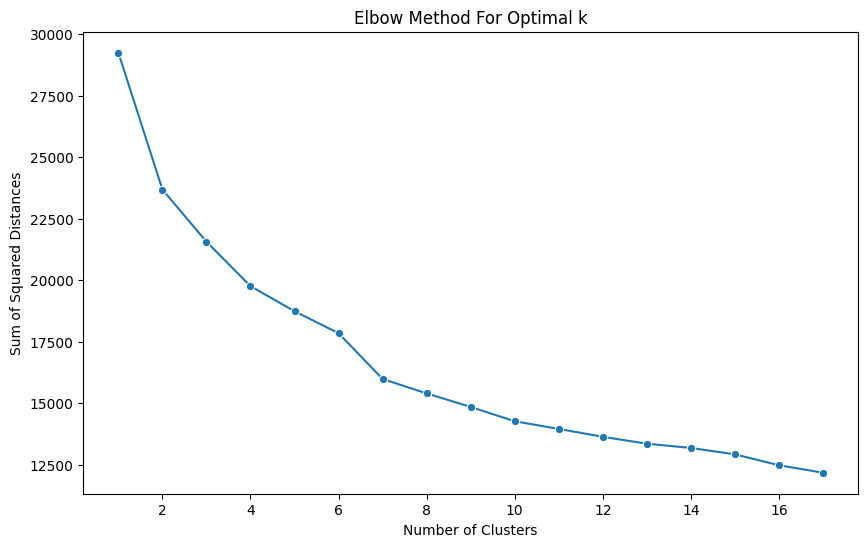

In [3]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# (a) - Optimal no. of cluster w/ elbow method

## Filter only numerical columns, as we don't want to work with categorical columns-
data_for_clustering = df[["age", "cigsPerDay", "totChol", "sysBP", "diaBP", "BMI", "heartRate", "glucose"]]

## - Standardise because K-Means is sensible to sizes, we standardize only numerical columns-
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_clustering)


ssd = []
range_n_clusters = list(range(1, 18))
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data_scaled)
    ssd.append(kmeans.inertia_)

# Plotting the Sum of Squared Distances (SSD) for each k
plt.figure(figsize=(10, 6))
sns.lineplot(x=range_n_clusters, y=ssd, marker="o", dashes=False)
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Distances')
plt.show()

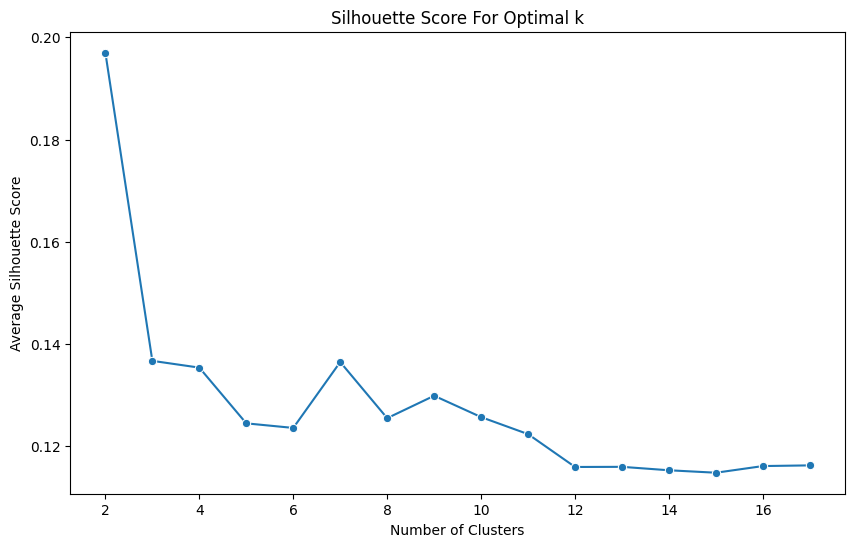

In [4]:
from sklearn.metrics import silhouette_score

# (b) - optimal number of clusters with Silhouette score


silhouette_scores = []
range_n_clusters = list(range(2, 18)) 

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)


plt.figure(figsize=(10, 6))
sns.lineplot(x=range_n_clusters, y=silhouette_scores, marker="o", dashes=False)
plt.title('Silhouette Score For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Silhouette Score')
plt.show()

### (c) - Decide the number of clusters

Considering the elbow method plot and the Silhouette score plot, I choose to select **4** as the number of clusters

Total variability captured by PCA: 44.72%


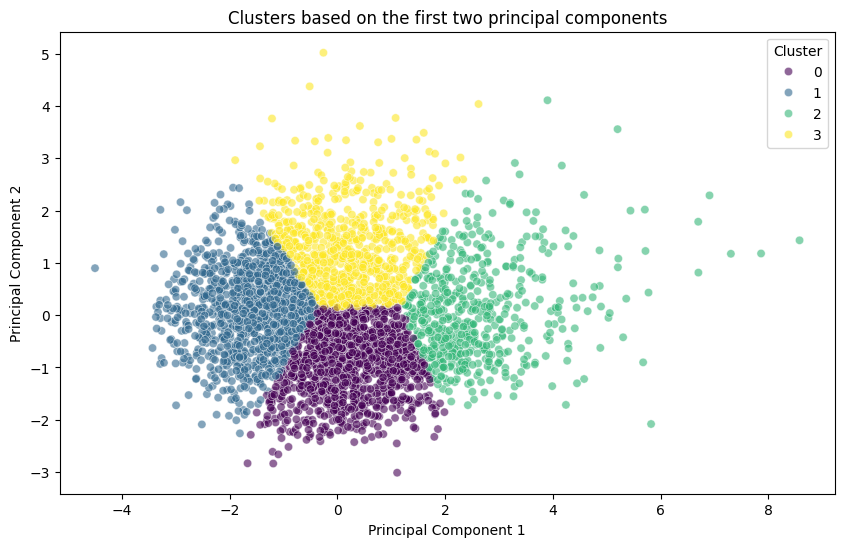

In [5]:
from sklearn.decomposition import PCA

# (d) - Plot the clusters using the first two principal components (use PCA)

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(data_scaled)
print(f"Total variability captured by PCA: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")

kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(principalComponents)

# Create a DataFrame with PCA results and cluster labels
pca_df = pd.DataFrame(data=principalComponents, columns=['Principal Component 1', 'Principal Component 2'])
pca_df['Cluster'] = cluster_labels

# Plotting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.6)
plt.title('Clusters based on the first two principal components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

## Q2 - Evaluation K-Means with unsupervised ML

In [6]:
# (a) Equate number of 0 and 1 with oversampling
from sklearn.utils import resample

response_count = df.groupby("TenYearCHD")["TenYearCHD"].count()
print("==Before upsampling==")
print(response_count)

# Model Evaluation - Undersampling
df_minority = df[(df['TenYearCHD']==1)]
df_majority = df[(df['TenYearCHD']==0)]

df_minority_upsampled = resample(df_minority, replace=True, n_samples=response_count[0], random_state=42)
df_minority_upsampled.reset_index(drop=True, inplace=True)

df_upsampled = pd.concat([df_minority_upsampled, df_majority])
response_count = df_upsampled.groupby("TenYearCHD")["TenYearCHD"].count()
print("==After upsampling==")
print(response_count)

==Before upsampling==
TenYearCHD
0    3099
1     557
Name: TenYearCHD, dtype: int64
==After upsampling==
TenYearCHD
0    3099
1    3099
Name: TenYearCHD, dtype: int64


In [7]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# (b) Cluster analysis using K=2

X = df_upsampled.drop('TenYearCHD', axis=1)
y = df_upsampled['TenYearCHD']  # Actual labels

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)
clusters = kmeans.labels_

# Align cluster with labels using majority rule
cluster_label_mapping = {0: 1 if sum(clusters) > len(clusters) / 2 else 0,
                         1: 0 if sum(clusters) > len(clusters) / 2 else 1}
predicted_labels = [cluster_label_mapping[x] for x in clusters]

# 4. Evaluate the clusters
print(f"Confusion Matrix\n{confusion_matrix(y, predicted_labels)}")
print(f"Classification Report\n{classification_report(y, predicted_labels)}")

Confusion Matrix
[[2292  807]
 [1620 1479]]
Classification Report
              precision    recall  f1-score   support

           0       0.59      0.74      0.65      3099
           1       0.65      0.48      0.55      3099

    accuracy                           0.61      6198
   macro avg       0.62      0.61      0.60      6198
weighted avg       0.62      0.61      0.60      6198



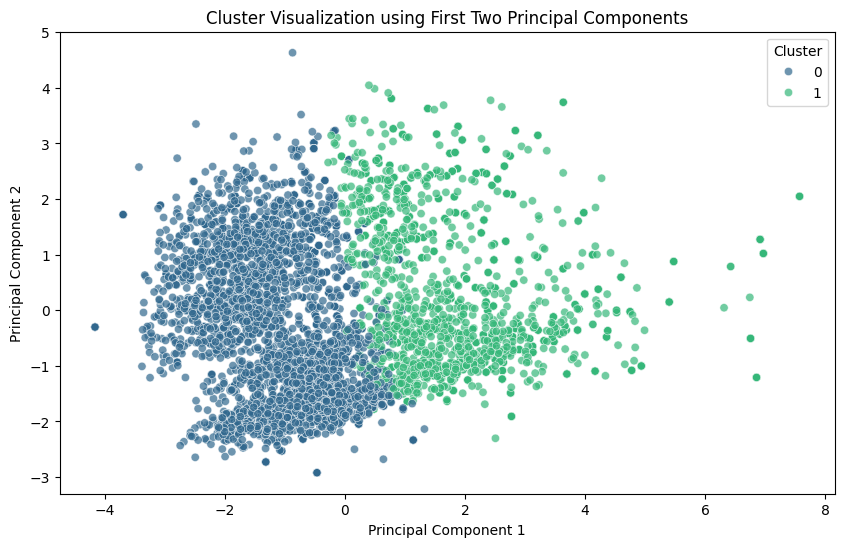

In [8]:
# (c) - Plot cluster with first 2 principal components

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data = principalComponents, columns = ['Principal Component 1', 'Principal Component 2'])
pca_df['Cluster'] = clusters 

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.7)
plt.title('Cluster Visualization using First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

In [9]:
# Last step (e)

conf_matrix = confusion_matrix(y, predicted_labels)
TN, FP, FN, TP = conf_matrix.ravel()

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

Accuracy: 0.6084
Sensitivity: 0.4773
Specificity: 0.7396
